Notebook que realiza a otimização e salva os melhores hiperparâmetros.

In [1]:
import sys
sys.path.append('..')
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances
import matplotlib.pyplot as plt
import torch
from torch.optim.adam import Adam
from src.data.data import LoFiDataset
from torch.utils.data import DataLoader, random_split
from src.models.vae import LSTMVAE
from src.utils.utils import train, save_sample
from src.utils.metrics import VAELoss
from src.optimization.optuna_vae import lstm_objective

c:\Users\Suporte\Anaconda3\envs\AMAP_Proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


Total de arquivos: 2611


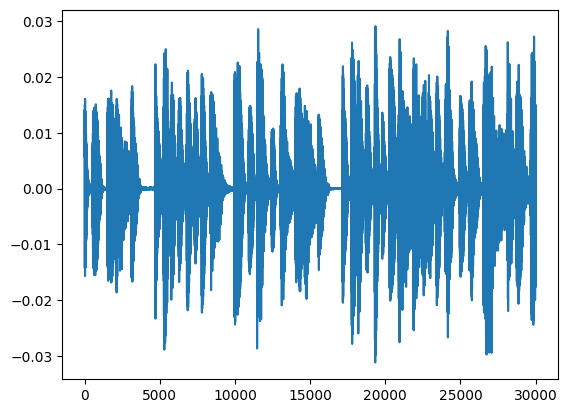

In [3]:
dataset = LoFiDataset('../data/raw')
print(f"Total de arquivos: {len(dataset)}")
plt.plot(dataset[30])
plt.show()

In [4]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: lstm_objective(trial, dataset, device, n_epochs=5), n_trials=1)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print(f"Número de trials finalizadas: {len(study.trials)}")
print(f"Número de trials podadas: {len(pruned_trials)}")
print(f"Número de trials completas: {len(complete_trials)}")

[I 2025-02-17 20:56:43,095] A new study created in memory with name: no-name-1baca1a4-1275-43e5-aa40-dbc57ea035fb


	[TRAINING] Epoch 1 	Average train Loss:  0.019068235008462303 	Average test Loss:  0.0010457741137703553
	[INFO] Best model saved at epoch 1, test loss: 0.0010457741137703553
	[TRAINING] Epoch 2 	Average train Loss:  0.0009731464070324419 	Average test Loss:  0.0007286133203545914
	[INFO] Best model saved at epoch 2, test loss: 0.0007286133203545914
	[TRAINING] Epoch 3 	Average train Loss:  0.0007423979343112671 	Average test Loss:  0.0006222661399720784
	[INFO] Best model saved at epoch 3, test loss: 0.0006222661399720784
	[TRAINING] Epoch 4 	Average train Loss:  0.0006582503366658012 	Average test Loss:  0.0005788849358556463
	[INFO] Best model saved at epoch 4, test loss: 0.0005788849358556463
	[TRAINING] Epoch 5 	Average train Loss:  0.000628889734137126 	Average test Loss:  0.0005518140370601459


[I 2025-02-17 21:00:52,225] Trial 0 finished with value: 0.000628889734137126 and parameters: {'num_layers': 4, 'original_size': 29999, 'latent_dim': 399, 'output_neurons': 300, 'middle_ground': 365}. Best is trial 0 with value: 0.000628889734137126.


	[INFO] Best model saved at epoch 5, test loss: 0.0005518140370601459
Número de trials finalizadas: 1
Número de trials podadas: 0
Número de trials completas: 1


In [5]:
best_params = study.best_params
best_params

{'num_layers': 4,
 'original_size': 29999,
 'latent_dim': 399,
 'output_neurons': 300,
 'middle_ground': 365}

In [6]:
plot_optimization_history(study)

In [7]:
plot_parallel_coordinate(study)

In [ ]:
#plot_param_importances(study)

ValueError: Cannot evaluate parameter importances with only a single trial.

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
batch_size = 32

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
best_params["device"] = device
lstm_model = LSTMVAE(**best_params)
optimizer = Adam(lstm_model.parameters(), lr=1e-3)
loss_function = VAELoss()
loss_curve = train(lstm_model, train_loader, test_loader, loss_function, optimizer, epochs=1, device=device)

	[TRAINING] Epoch 1 	Average train Loss:  6.077879123163946 	Average test Loss:  1.4015113921726452


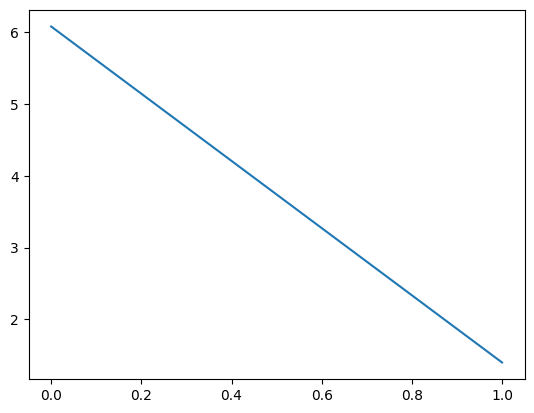

In [ ]:
plt.plot(loss_curve)
plt.show()

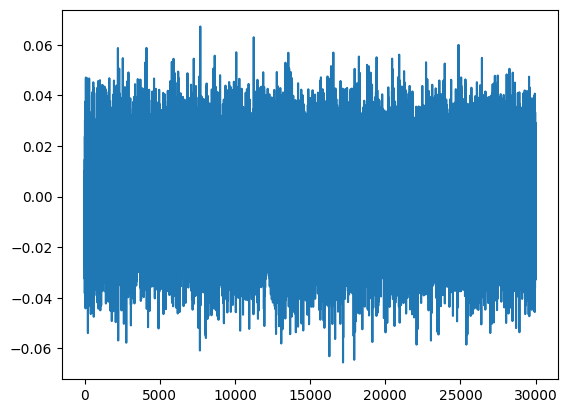

In [ ]:
a = lstm_model.sample(scale=2)
b = save_sample(a, "../data/processed/output.wav")
plt.plot(b[0])
plt.show()